In [1]:
import sys
sys.path.append(r'../')
import mat73
import numpy as np
from tqdm import tqdm
from scipy import signal
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.animation as animation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

%reload_ext autoreload
%autoreload 2
from functions import *

2023-04-06 14:35:40.206291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 14:35:40.285841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-06 14:35:40.285853: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-06 14:35:40.305593: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-06 14:35:40.769563: W tensorflow/stream_executor/platform/de

In [2]:
data = Database()
X = data.neuron_traces.T
B = data.states

## Preprocessing the data

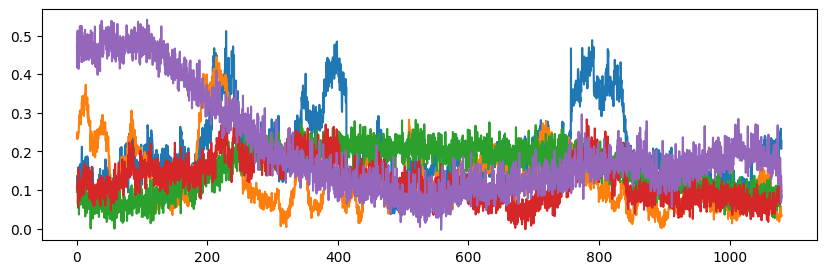

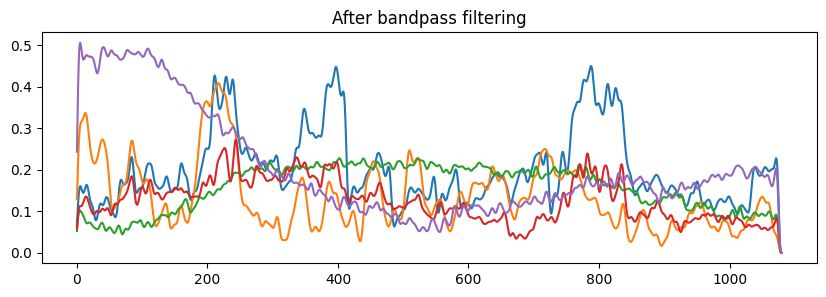

In [3]:
time = 1/data.fps*np.arange(0,X.shape[0])
filtered = bandpass(X.T, f_l=1e-10, f_h=0.072, sampling_freq=float(data.fps)).T

nn = np.arange(80,85)
plt.figure(figsize = [10,3])
plt.plot(time, X[:,nn])
plt.figure(figsize = [10,3])
plt.plot(time, filtered[:,nn])
plt.title('After bandpass filtering')
plt.show()

X = filtered

### Preparing the data  

In [7]:
# Preparing the data (Method new)
win = 1
win += 1
gap = 1
X_win = np.zeros((X.shape[0]-win-gap, win, X.shape[1]))

for i, _ in enumerate(X_win):
    X_win[i] = X[i:i+win]

Xwin0, Xwin1 = X_win[:,:-1,:], X_win[:,1:,:]
B_1 = B[1:]
X_paired = np.array([Xwin0, Xwin1])
X_paired = np.transpose(X_paired, axes=(1,0,2,3))

# Train test split 
kf = KFold(n_splits=7)
for i, (train_index, test_index) in enumerate(kf.split(X_win)):
    if i==4: 
        # Train test split based on a fold
        X_train, X_test = X_paired[train_index], X_paired[test_index]
        B_train_1, B_test_1 = B_1[train_index], B_1[test_index]        

### Calculating participation ratio


Participation ratio:  3.513


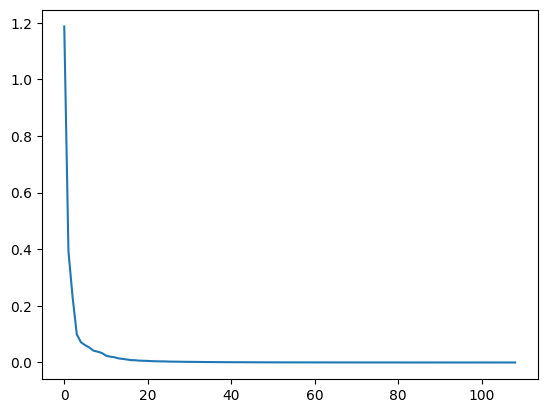

In [8]:
cov = np.cov(X_train[:,0,0,:].T)
eigvals, eigvecs = np.linalg.eig(cov)
plt.plot(eigvals)
PR = (np.sum(eigvals)**2) / (np.sum(eigvals**2))
print('Participation ratio: ', PR.round(3))

## t-SNE

In [24]:
dim = 3
tsne = TSNE(n_components=dim, init='pca', perplexity=80)

#### Projecting into latent space

In [25]:
Y0_tr = tsne.fit_transform(X_train[:,0,0,:])
Y1_tr = tsne.fit_transform(X_train[:,1,0,:])
#Ydiff_tr = Y1_tr - Y0_tr

# tsne does not have transform method alone only fittransform. Hence it 
# cannot be run separately on held out test data. So we set the test data
# equal to the train data
Y0_tst = Y0_tr.copy()
Y1_tst = Y1_tr.copy()
B_test_1 = B_train_1.copy()

np.savetxt('Saved_Y/Y0_tr__tsne.csv',Y0_tr)
np.savetxt('Saved_Y/Y1_tr__tsne.csv',Y1_tr)
np.savetxt('Saved_Y/Y0_tst__tsne.csv',Y0_tr)
np.savetxt('Saved_Y/Y1_tst__tsne.csv',Y1_tr)

np.savetxt('Saved_Y/B_train_1__tsne.csv',B_train_1)
np.savetxt('Saved_Y/B_test_1__tsne.csv',B_test_1)

/home/akshey/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/akshey/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/akshey/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/akshey/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


#### Plotting first 3 PCs


(0.0, 2686.0, -0.5, 0.5)

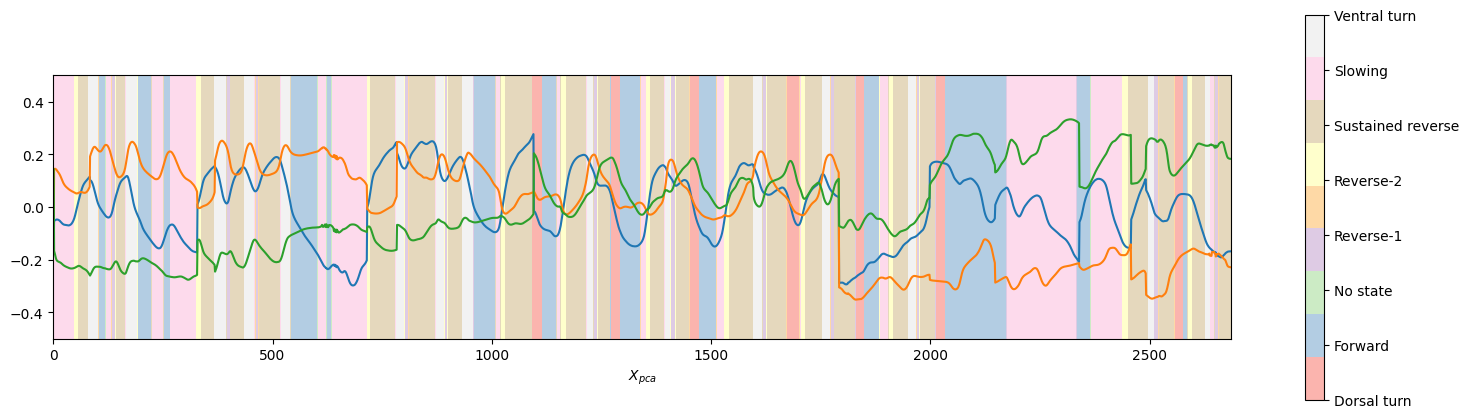

In [26]:
%matplotlib inline
plt.figure(figsize=(19,5))
plt.imshow([B],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y0_tr/Y0_tr.max()/3)
plt.xlabel("time $t$")
plt.xlabel("$X_{pca}$")
plt.axis([0,Y0_tr.shape[0],-0.5,0.5])


<IPython.core.display.Javascript object>


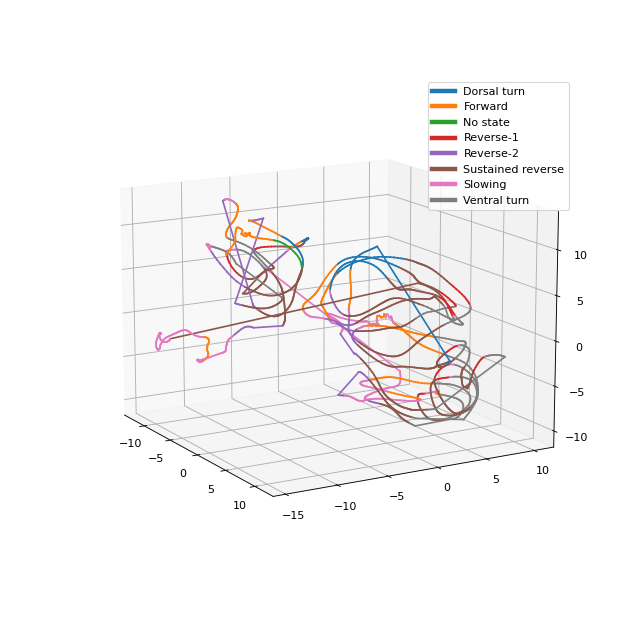

<Axes3DSubplot: >

In [27]:
%matplotlib notebook
plot_phase_space(Y0_tr, B_train_1)

In [44]:
### Run to produce rotating 3-D plot
#%matplotlib notebook    
#rotating_plot(Y0_tr, B_train_1)

## Without separate train and test set

In [63]:
dim = 3
tsne = TSNE(n_components=dim, init='pca', perplexity=70)

#### Projecting into latent space
Y0_ = tsne.fit_transform(X_paired[:,0,0,:])
Y1_ = tsne.fit_transform(X_paired[:,1,0,:])

/home/akshey/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/akshey/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/akshey/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/akshey/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


#### Plotting first 3 PCs


(0.0, 3134.0, -0.5, 0.5)

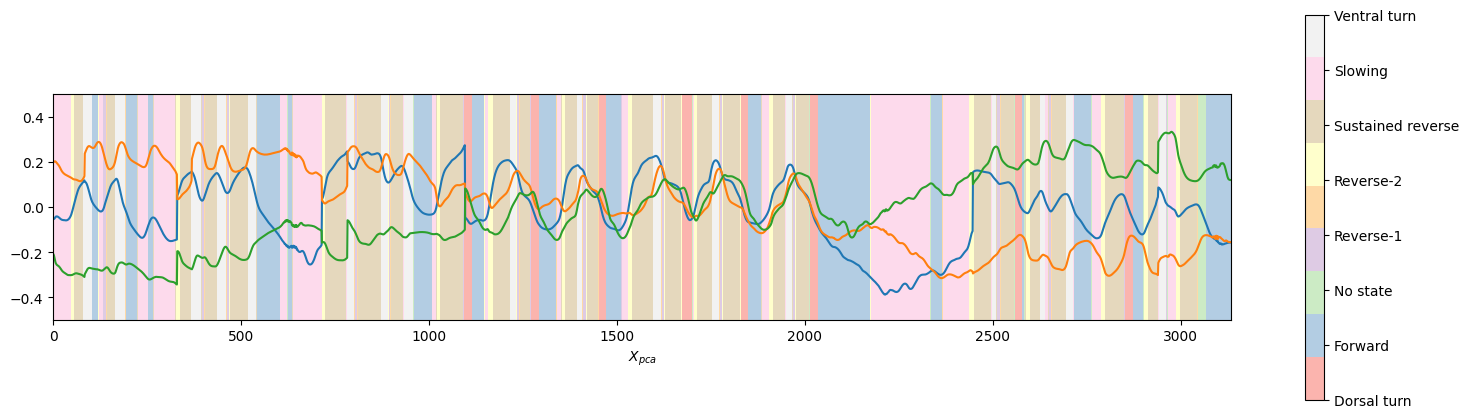

In [64]:
%matplotlib inline
plt.figure(figsize=(19,5))
plt.imshow([B],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y0_/Y0_.max()/3)
plt.xlabel("time $t$")
plt.xlabel("$X_{pca}$")
plt.axis([0,Y0_.shape[0],-0.5,0.5])

<IPython.core.display.Javascript object>


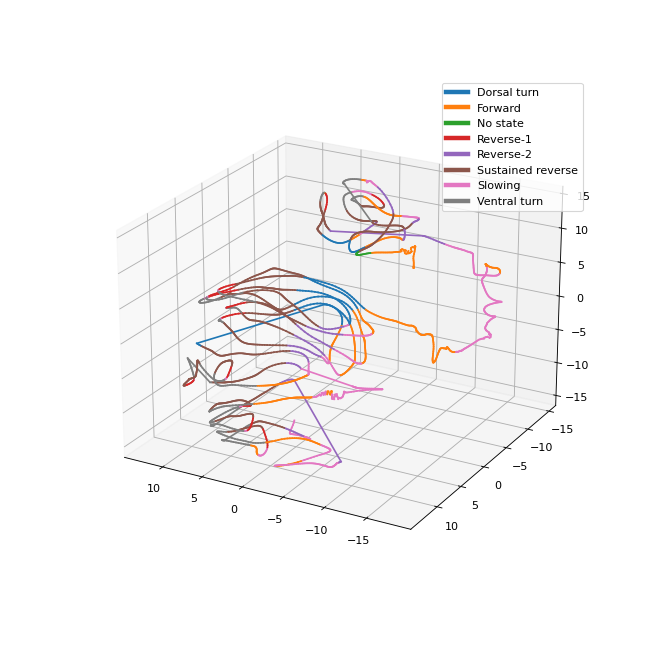

<Axes3DSubplot: >

In [66]:
%matplotlib notebook
plot_phase_space(Y0_, B)